## Importing Modules

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score,\
roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import eli5
import pickle
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fahadmehfooz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fahadmehfooz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/fahadmehfooz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## About the data:

Dataset using Twitter data, is was used to research hate-speech detection. The text is classified as: hate-speech, offensive language, and neither. Due to the nature of the study, it’s important to note that this dataset contains text that can be considered racist, sexist, homophobic, or generally offensive.


class label is 0 - hate speech,  1 - offensive language,  2 - neither

Count -number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF)

Hate Speech- number of CF users who judged the tweet to be hate speech

Offensive language- number of CF users who judged the tweet to be offensive

Neither - number of CF users who judged the tweet to be neither offensive nor non-offensive

Tweet - text tweet




## Problem Statement: 

Detecting hate speech is a critical challenge in natural language processing (NLP)
systems. Hate speech involves the use of offensive language, discriminatory remarks, or
expressions of prejudice against individuals or groups based on attributes such as race,
religion, ethnicity, gender, or other protected characteristics. NLP algorithms currently face
difficulties in accurately identifying hate speech, posing a threat to online communication
platforms and user safety.

In [3]:
df = pd.read_csv(r"labeled_data.csv").drop(columns=['Unnamed: 0'])
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
df["class"] = df["class"].astype(int)
df["class"] = df["class"].apply(lambda x : 0 if x==2 else 1)


## Out of all the tweets, in which category is a tweet classified?

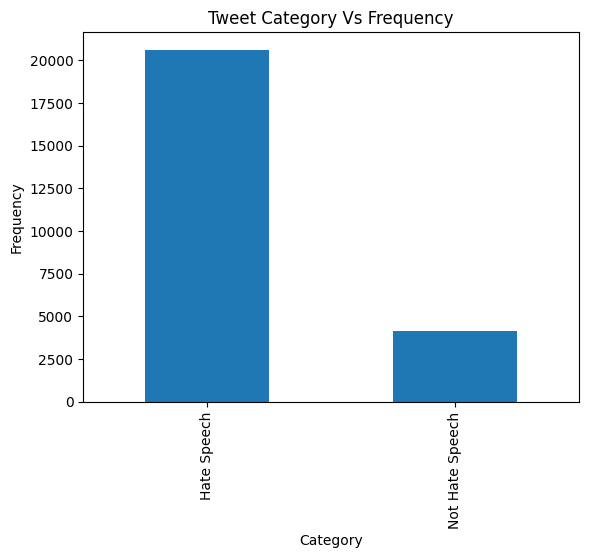

In [5]:
df["class"].map({0: "Not Hate Speech", 1 : "Hate Speech"}).value_counts().plot(kind = "bar");
plt.title("Tweet Category Vs Frequency");
plt.xlabel("Category");
plt.ylabel("Frequency");
plt.show()

> A clear class imbalance can be seen here.

In [6]:
df["class"].value_counts()

1    20620
0     4163
Name: class, dtype: int64

In [7]:
def clean_the_text(text):
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    # Removing special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Removing words with repeated characters
    text = re.sub(r'\b(\w)\1+\b', '', text)
    
    # Tokenizing text
    tokens = text.lower().split()
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

def plot_confusion_matrices(cm_train, cm_test, title_train, title_test):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for ax, cm, title in zip(axes, [cm_train, cm_test], [title_train, title_test]):
        cax = ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(title)

    plt.colorbar(cax, ax=axes.ravel().tolist(), shrink=0.5)
    plt.show()
    
def plot_roc_curves_subplots(y_train, y_score_train, y_test, y_score_test, n_classes, title_train, title_test):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Function to compute and plot ROC curve and AUC for each subplot
    def compute_and_plot_roc(ax, y_true, y_score, n_classes, title):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        colors = ['blue', 'red', 'green', 'purple', 'orange']
        for i, color in zip(range(n_classes), colors):
            ax.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(title)
        ax.legend(loc="lower right")

    # Plot for training data
    compute_and_plot_roc(axes[0], y_train, y_score_train, n_classes, title_train)
    
    # Plot for testing data
    compute_and_plot_roc(axes[1], y_test, y_score_test, n_classes, title_test)

    plt.show()
    
    

def plot_precision_recall_curves_subplots(y_train, y_scores_train, y_test, y_scores_test, n_classes, title_train, title_test):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Function to compute and plot precision-recall curve for each subplot
    def compute_and_plot_pr_curve(ax, y_true, y_scores, n_classes, title):
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_scores[:, i])
            average_precision[i] = average_precision_score(y_true == i, y_scores[:, i])

        colors = ['blue', 'red', 'green', 'purple', 'orange']
        for i, color in zip(range(n_classes), colors):
            ax.plot(recall[i], precision[i], color=color, lw=2,
                    label='PR curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_title(title)
        ax.legend(loc="lower left")

    # Plot for training data
    compute_and_plot_pr_curve(axes[0], y_train, y_scores_train, n_classes, title_train)
    
    # Plot for testing data
    compute_and_plot_pr_curve(axes[1], y_test, y_scores_test, n_classes, title_test)

    plt.show()

def calculate_chi2_contingency(table):
    chi2, p, dof, expected = chi2_contingency(table)
    return chi2, p

def cramers_v(chi2, n, k1, k2):
    """Calculate Cramér's V statistic for a given chi-squared value."""
    return np.sqrt(chi2 / (n * min(k1 - 1, k2 - 1)))

def evaluate_model(model, X_train, y_train, X_test, y_test, n_classes=2):
    # Fitting the model on the training data
    model.fit(X_train, y_train)

    # Predicting on the training and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    plot_confusion_matrices(confusion_matrix(y_train, y_pred_train), confusion_matrix(y_test, y_pred_test), 'Confusion Matrix for Training Data', 'Confusion Matrix for Testing Data')

    # Calculating metrics for training data
    metrics_train = {
        'Accuracy': accuracy_score(y_train, y_pred_train),
        'Precision': precision_score(y_train, y_pred_train),
        'Recall': recall_score(y_train, y_pred_train),
        'F1 Score': f1_score(y_train, y_pred_train),
        'ROC AUC Score': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    }

    # Calculating metrics for testing data
    metrics_test = {
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1 Score': f1_score(y_test, y_pred_test),
        'ROC AUC Score': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }

    # Printing out the metrics for training and testing data
    print("Training Data Metrics:\n")
    for metric, value in metrics_train.items():
        print(f"{metric}: {value}")

    print("\nTesting Data Metrics:\n")
    for metric, value in metrics_test.items():
        print(f"{metric}: {value}")
        
    plot_precision_recall_curves_subplots(
        y_train, model.predict_proba(X_train), 
        y_test, model.predict_proba(X_test), 
        n_classes=n_classes, 
        title_train='Precision-Recall Curve (Train)', 
        title_test='Precision-Recall Curve (Test)'
    )
    
    plot_roc_curves_subplots(
        y_train, model.predict_proba(X_train), 
        y_test, model.predict_proba(X_test), 
        n_classes=n_classes, 
        title_train='ROC for Binary Classification (Train)', 
        title_test='ROC for Binary Classification (Test)'
    )
    
    return model, metrics_train, metrics_test

def combine_train_test_metrics(model_name, metrics_train, metrics_test):
    # Creating a DataFrame for each set of metrics
    df_train = pd.DataFrame({f'{model_name} Train': metrics_train})
    df_test = pd.DataFrame({f'{model_name} Test': metrics_test})

    # Concatenating the training and testing metrics side by side
    return pd.concat([df_train, df_test], axis=1)


In [8]:
# Cleaning the tweet column
df['cleaned_tweet'] = df['tweet'].apply(clean_the_text)


##  Splitting The Data into X and Y

In [9]:
# Splitting the dataset into features and target
X = df.drop(['class', 'tweet', 'offensive_language', 'neither'], axis=1)  # Features
y = df['class']  # Target


In [10]:
for col in list(set([col for col in df.columns  if df[col].dtype != object])  - set(["class"])):
    contingency_table_1 = pd.crosstab(df['class'], df[col])
    chi2_1, p_1 = calculate_chi2_contingency(contingency_table_1)
    cramers_v_1 = cramers_v(chi2_1, len(df), len(contingency_table_1), len(contingency_table_1.columns))

    print(f"Categorical Variable class and {col} : Chi2 = {chi2_1}, p-value = {p_1}, Cramér's V = {cramers_v_1}")
    print( )


Categorical Variable class and offensive_language : Chi2 = 18472.197675180316, p-value = 0.0, Cramér's V = 0.863340958759233

Categorical Variable class and count : Chi2 = 35.165298022884855, p-value = 4.295959526745685e-07, Cramér's V = 0.037668663605791755

Categorical Variable class and hate_speech : Chi2 = 650.7123501561354, p-value = 2.8991423596021918e-136, Cramér's V = 0.16203826571022478

Categorical Variable class and neither : Chi2 = 24545.672985791047, p-value = 0.0, Cramér's V = 0.9952003808270307



In [11]:
# Performing a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
df.corr()

/var/folders/1b/6_jlthxx5rj3h57f1wxl2r9c0000gn/T/ipykernel_11276/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,count,hate_speech,offensive_language,neither,class
count,1.000000,0.101926,0.534604,0.063326,0.036006
hate_speech,0.101926,1.000000,-0.261808,-0.157599,0.154729
offensive_language,0.534604,-0.261808,1.000000,-0.684406,0.690145
neither,0.063326,-0.157599,-0.684406,1.000000,-0.926796
class,0.036006,0.154729,0.690145,-0.926796,1.000000


In [13]:
# Splitting the 'cleaned_tweet' from the remaining features
X_train_tweets = X_train['cleaned_tweet']
X_train_remaining = X_train.drop('cleaned_tweet', axis=1)


X_test_tweets = X_test['cleaned_tweet']
X_test_remaining = X_test.drop('cleaned_tweet', axis=1)


## Creating numeric features from textual representation

In [14]:
# Creating a TF-IDF vectorizer
tfidf_vectorizer = CountVectorizer(min_df=0.005)

# Fitting the TF-IDF vectorizer on the training 'cleaned_tweet' data and transforming it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tweets)

# Only transforming the 'cleaned_tweet' test data into TF-IDF vectors to avoid data leakage
X_test_tfidf = tfidf_vectorizer.transform(X_test_tweets)


# Converting the TF-IDF vectors into a DataFrame
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=X_train_remaining.index)
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=X_test_remaining.index)

X_train_tfidf_df.shape, X_test_tfidf_df.shape

((19826, 216), (4957, 216))

In [15]:
# Merging the TF-IDF features with the remaining features
X_train_final = X_train_tfidf_df
X_test_final = X_test_tfidf_df


In [16]:
X_train_final.shape

(19826, 216)

In [17]:
X_train_final.corr()

,act,aint,already,always,amp,another,around,as,baby,back,...,would,ya,yall,yankee,yeah,year,yellow,yes,yo,youre
act,1.000000,0.008834,0.004133,-0.001054,0.001226,-0.005515,-0.006263,0.006109,0.009950,0.000265,...,0.002185,0.004238,0.008613,-0.002656,-0.006519,-0.006512,-0.007295,-0.005042,-0.010716,-0.010516
aint,0.008834,1.000000,-0.005948,0.001292,-0.003722,0.012495,-0.000482,0.013456,0.008850,0.002688,...,-0.020021,0.028701,0.026960,-0.023322,-0.002472,-0.012302,-0.019171,-0.011788,0.039339,-0.015717
already,0.004133,-0.005948,1.000000,-0.007414,0.011770,-0.005512,0.001643,0.001290,0.010248,-0.004559,...,0.013481,0.013506,0.012883,0.013778,0.000834,0.007354,0.005760,0.004024,-0.006643,0.006398
always,-0.001054,0.001292,-0.007414,1.000000,-0.008151,0.003153,0.018044,0.013232,-0.008331,-0.010291,...,-0.012462,0.002465,0.000901,-0.007736,-0.009337,-0.004588,0.016319,-0.001026,-0.007007,0.002278
amp,0.001226,-0.003722,0.011770,-0.008151,1.000000,0.007427,0.002346,0.004220,0.018196,0.004559,...,0.001493,0.003094,0.024482,-0.009060,-0.004774,-0.005362,0.020513,0.007748,0.004091,-0.004979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
year,-0.006512,-0.012302,0.007354,-0.004588,-0.005362,0.010790,0.021006,0.009224,-0.007313,0.024601,...,-0.006887,-0.004774,0.003855,0.045643,0.002547,1.000000,0.019445,-0.006340,-0.004555,-0.007043
yellow,-0.007295,-0.019171,0.005760,0.016319,0.020513,0.003356,-0.003384,-0.013278,-0.008193,0.000308,...,-0.000810,-0.006527,-0.014870,-0.011267,0.005990,0.019445,1.000000,-0.007103,-0.012295,-0.008995
yes,-0.005042,-0.011788,0.004024,-0.001026,0.007748,-0.005370,0.001455,-0.009143,-0.005663,-0.009325,...,-0.008471,-0.004491,-0.010279,-0.007789,0.000677,-0.006340,-0.007103,1.000000,0.001229,0.001882
yo,-0.010716,0.039339,-0.006643,-0.007007,0.004091,0.012856,0.000599,0.114646,-0.005146,0.010285,...,-0.001357,0.006434,-0.008443,-0.016551,0.014881,-0.004555,-0.012295,0.001229,1.000000,-0.014507


In [18]:
X_train_final.shape

(19826, 216)

In [19]:
# Computing class weights as the dataset is imbalanced
class_weights = compute_class_weight('balanced', classes=[0, 1], y=df["class"])
class_weights = dict(enumerate(class_weights))

## Modelling

### Logistic Regression

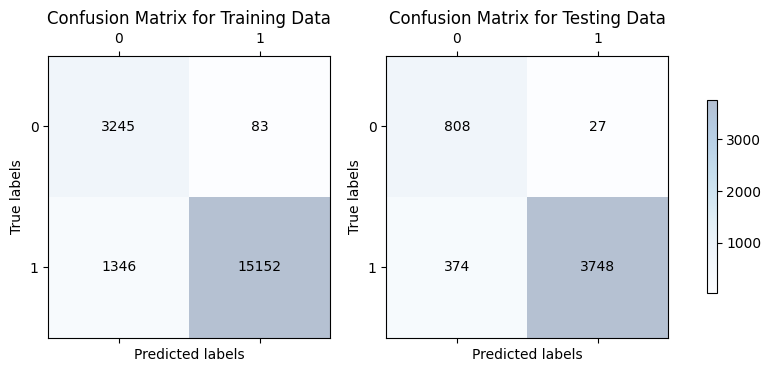

Training Data Metrics:

Accuracy: 0.9279229294865329
Precision: 0.9945520183787332
Recall: 0.91841435325494
F1 Score: 0.954968014369899
ROC AUC Score: 0.9787120448603328

Testing Data Metrics:

Accuracy: 0.9191042969538027
Precision: 0.9928476821192053
Recall: 0.9092673459485686
F1 Score: 0.9492212232493352
ROC AUC Score: 0.9700774578935288


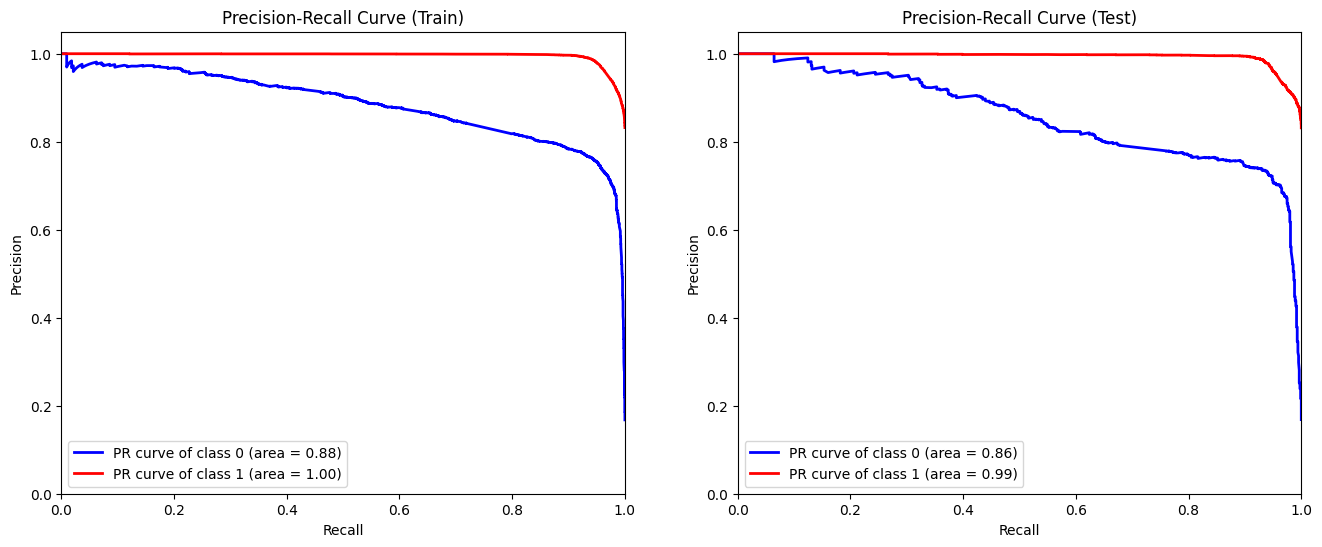

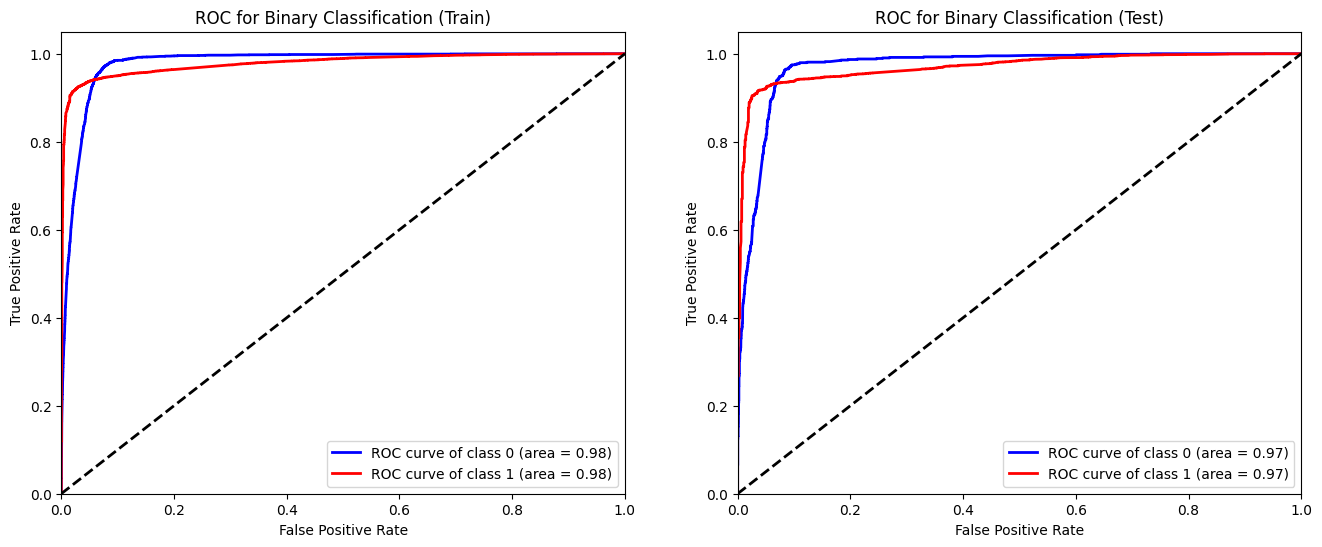

In [20]:
# Initializing logistic regression model
log_reg = LogisticRegression(class_weight = class_weights, random_state=42)

log_reg, lr_metrics_train, lr_metrics_test = evaluate_model(log_reg, X_train_final, y_train, X_test_final, y_test)

## Decision Tree

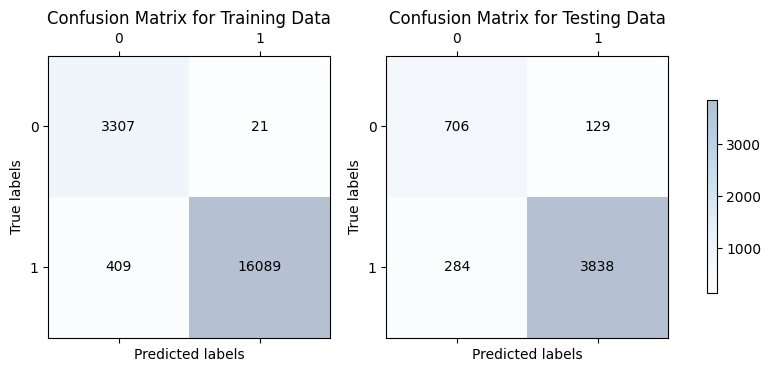

Training Data Metrics:

Accuracy: 0.9783113083829315
Precision: 0.9986964618249534
Recall: 0.975209116256516
F1 Score: 0.9868130520117762
ROC AUC Score: 0.9979914068109654

Testing Data Metrics:

Accuracy: 0.9166834779100262
Precision: 0.967481724224855
Recall: 0.9311014070839398
F1 Score: 0.9489430090246013
ROC AUC Score: 0.8911051259925564


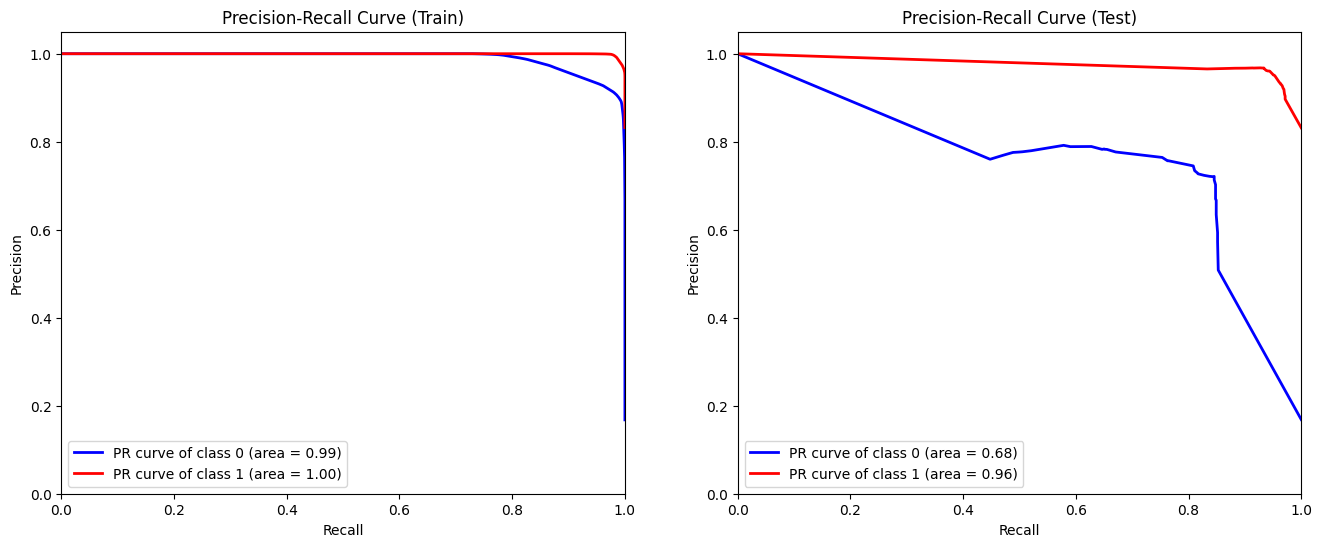

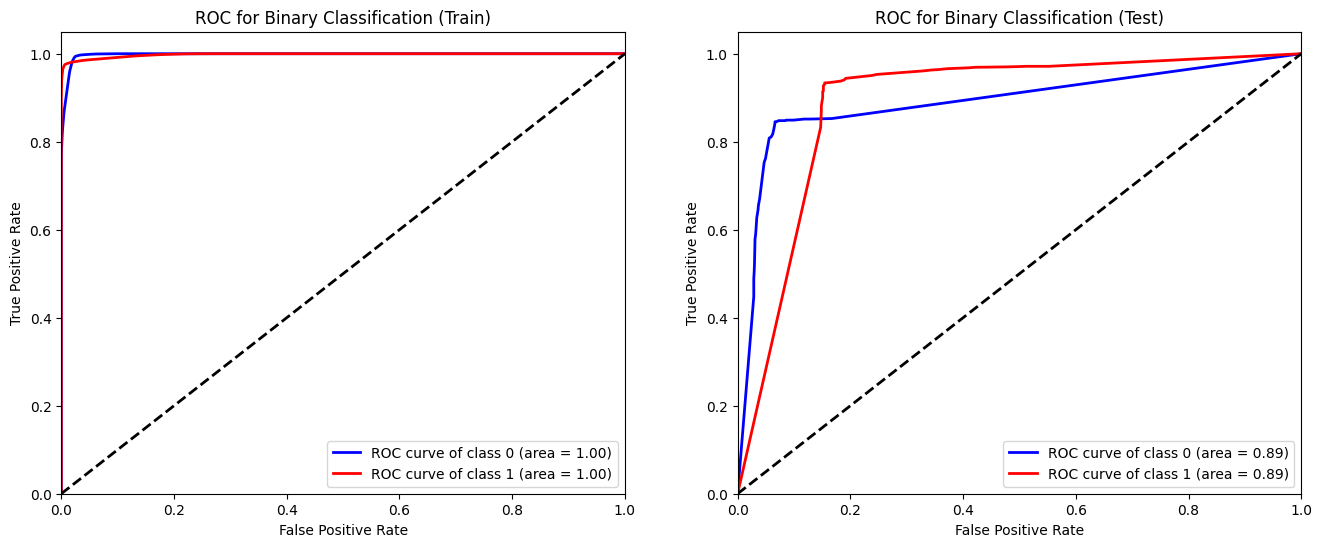

In [21]:
# Initializing Decision Tree model
dtree = DecisionTreeClassifier(class_weight = class_weights, random_state=42)

dtree, dtree_metrics_train, dtree_metrics_test = evaluate_model(dtree, X_train_final, y_train, X_test_final, y_test)

## Gradient Boosting

In [22]:
print("Before SMOTE the distribution for y training data looks like: ", Counter(y_train))

smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train)
print()
print("After SMOTE the distribution for y training data looks like: ", Counter(y_train_resampled))


Before SMOTE the distribution for y training data looks like:  Counter({1: 16498, 0: 3328})

After SMOTE the distribution for y training data looks like:  Counter({1: 16498, 0: 16498})


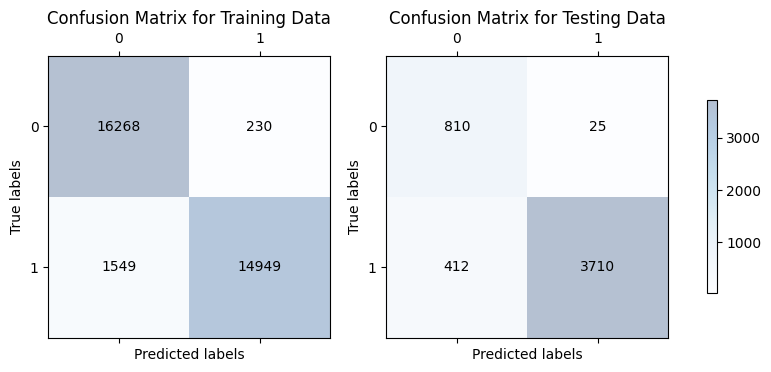

Training Data Metrics:

Accuracy: 0.9460843738634986
Precision: 0.9848474866592002
Recall: 0.9061098314947267
F1 Score: 0.9438393787290463
ROC AUC Score: 0.9748943273683343

Testing Data Metrics:

Accuracy: 0.9118418398224732
Precision: 0.9933065595716198
Recall: 0.9000485201358563
F1 Score: 0.9443808069237623
ROC AUC Score: 0.9665540825190957


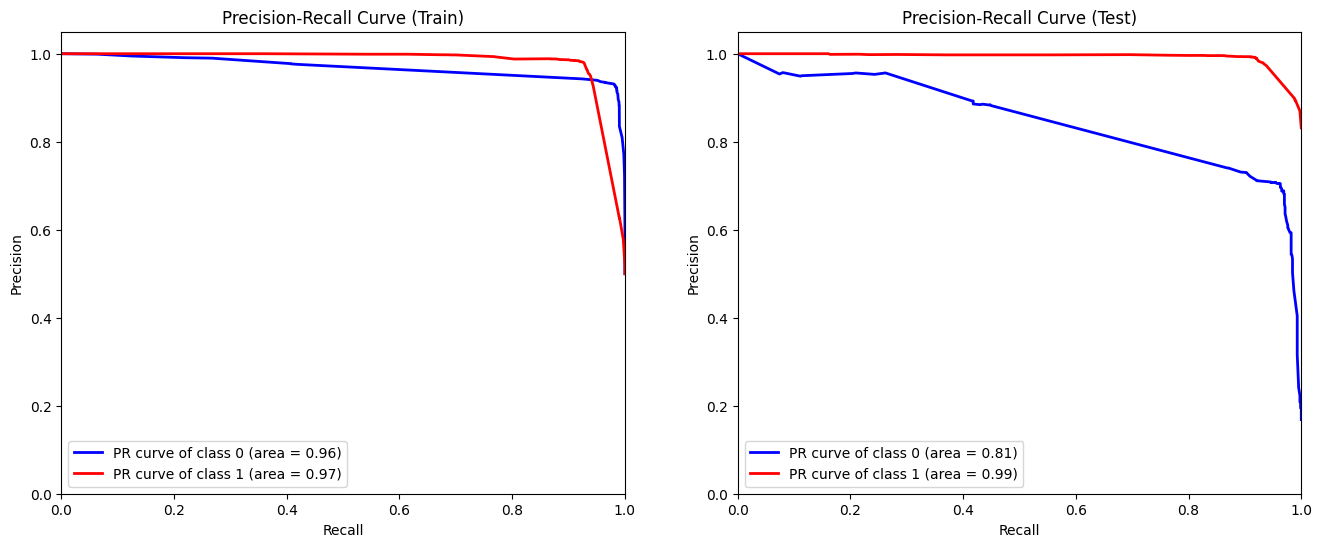

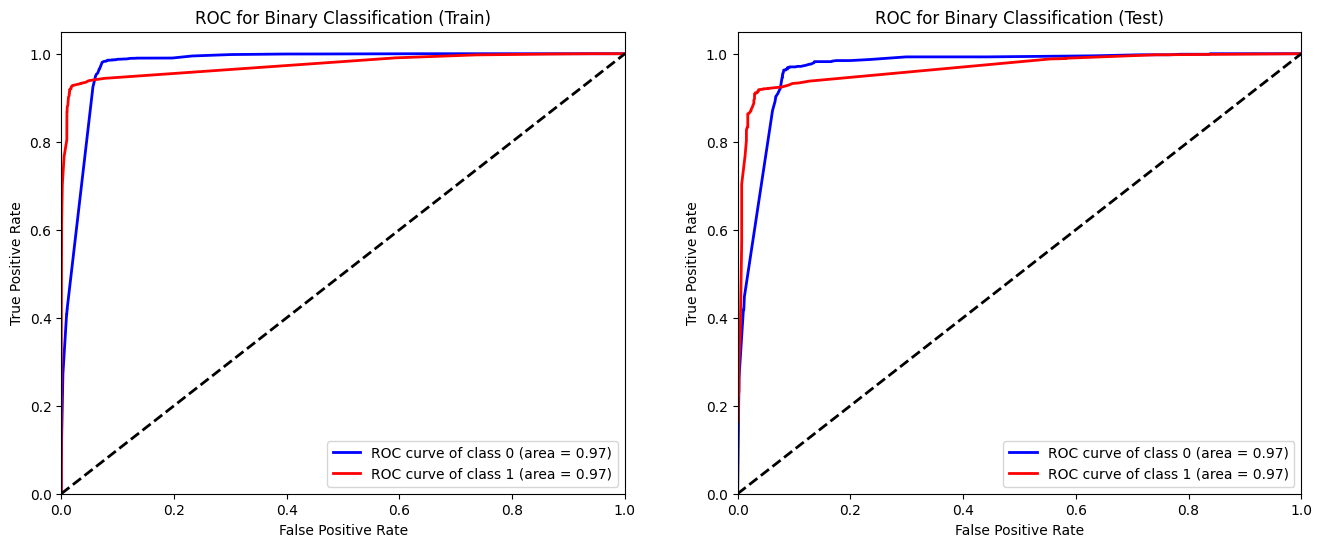

In [23]:
# Initializing Gradient Boosting model
gbm = GradientBoostingClassifier(random_state=42)

gbm, gbm_metrics_train, gbm_metrics_test = evaluate_model(gbm, X_train_resampled, y_train_resampled, X_test_final, y_test)

In [24]:
# Combining metrics for each model
combined_lr = combine_train_test_metrics("LR", lr_metrics_train, lr_metrics_test)
combined_gbm = combine_train_test_metrics("GBM", gbm_metrics_train, gbm_metrics_test)
combined_dtree = combine_train_test_metrics("DT", dtree_metrics_train, dtree_metrics_test)

# Combining all into a single DataFrame
combined_metrics_all_models = pd.concat([combined_lr, combined_gbm, combined_dtree], axis=1)

combined_metrics_all_models.T



,Accuracy,F1 Score,Precision,ROC AUC Score,Recall
LR Train,0.927923,0.954968,0.994552,0.978712,0.918414
LR Test,0.919104,0.949221,0.992848,0.970077,0.909267
GBM Train,0.946084,0.943839,0.984847,0.974894,0.906110
GBM Test,0.911842,0.944381,0.993307,0.966554,0.900049
DT Train,0.978311,0.986813,0.998696,0.997991,0.975209
DT Test,0.916683,0.948943,0.967482,0.891105,0.931101


### **Observation:**

> All the model are performing pretty good here.

> Decision tree seems to be performing good too but is not that stable. If you see the performance on the test dataset, it tends to overfit.

> We can choose any model from logistic regression or gbm.

> Lets choose GBM as our baseline model.

## Tuning the hyperparameters of GBM

In [25]:
# Initialize the GBM model
gbm = GradientBoostingClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=  3, n_jobs=-1, verbose=2,)

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled,)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
GBM_tuned = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best Score: 0.9528732444461726


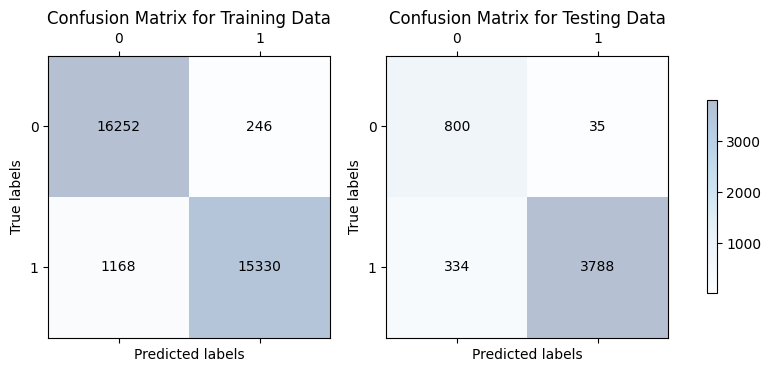

Training Data Metrics:

Accuracy: 0.9571463207661535
Precision: 0.984206471494607
Recall: 0.9292035398230089
F1 Score: 0.9559144478393714
ROC AUC Score: 0.9854583868198221

Testing Data Metrics:

Accuracy: 0.9255598144038734
Precision: 0.9908448862150144
Recall: 0.9189713731198448
F1 Score: 0.9535556954059158
ROC AUC Score: 0.9701437009532607


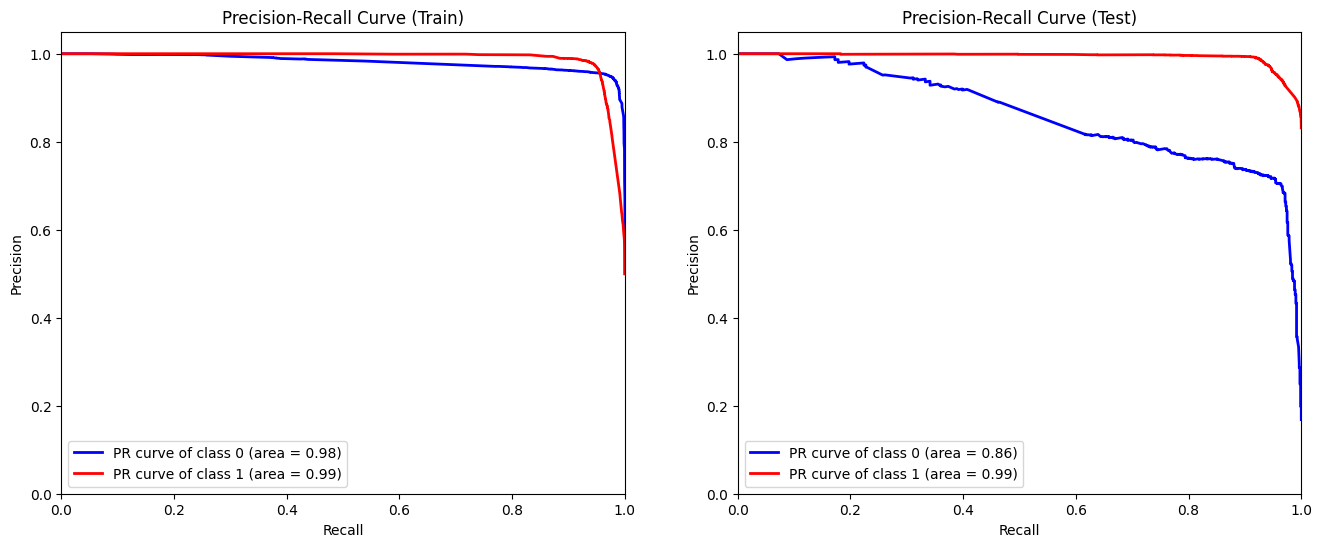

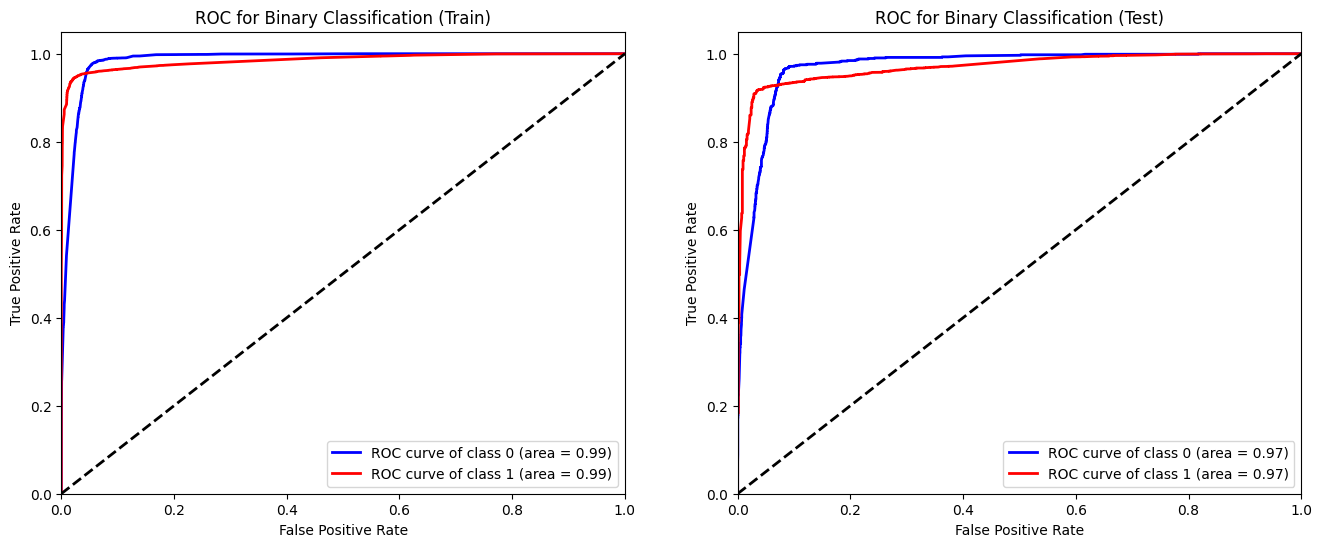

In [27]:
GBM_tuned, GBM_tuned_metrics_train, GBM_tuned_metrics_test = evaluate_model(GBM_tuned, X_train_resampled, y_train_resampled, X_test_final, y_test)

## Storing all objects

In [31]:
pickle.dump(GBM_tuned, open('GBM_tuned.pkl','wb'))
pickle.dump(tfidf_vectorizer, open('tfidf_vectorizer.pkl', 'wb'))
pickle.dump(smote, open('smote.pkl','wb'))


## Model Interpretation

In [29]:
eli5.show_weights(GBM_tuned, feature_names= list(X_train_final.columns), top = 100)

Weight,Feature
0.4428 ± 0.3125,bitch
0.2067 ± 0.1948,hoe
0.1354 ± 0.1722,pussy
0.0363 ± 0.1795,faggot
0.0226 ± 0.1754,nigger
0.0175 ± 0.1701,fag
0.0169 ± 0.1677,cunt
0.0159 ± 0.1677,niggah
0.0111 ± 0.1402,shit
0.0108 ± 0.1565,retarded


> the top words which are contributing to the model can be clearly seen here.

> Each word also has been assigned a specific weight.

## Final Results

In [30]:
# Combining metrics for each model
combined_lr = combine_train_test_metrics("LR", lr_metrics_train, lr_metrics_test)
combined_gbm = combine_train_test_metrics("GBM", gbm_metrics_train, gbm_metrics_test)
combined_dtree = combine_train_test_metrics("DT", dtree_metrics_train, dtree_metrics_test)
combined_tuned_gbm = combine_train_test_metrics("Tuned_GBM", GBM_tuned_metrics_train, GBM_tuned_metrics_test)

# Combining all into a single DataFrame
combined_metrics_all_models = pd.concat([combined_lr, combined_dtree,combined_gbm, combined_tuned_gbm], axis=1)

combined_metrics_all_models.T


,Accuracy,F1 Score,Precision,ROC AUC Score,Recall
LR Train,0.927923,0.954968,0.994552,0.978712,0.918414
LR Test,0.919104,0.949221,0.992848,0.970077,0.909267
DT Train,0.978311,0.986813,0.998696,0.997991,0.975209
DT Test,0.916683,0.948943,0.967482,0.891105,0.931101
GBM Train,0.946084,0.943839,0.984847,0.974894,0.906110
GBM Test,0.911842,0.944381,0.993307,0.966554,0.900049
Tuned_GBM Train,0.957146,0.955914,0.984206,0.985458,0.929204
Tuned_GBM Test,0.925560,0.953556,0.990845,0.970144,0.918971


> We see a minor improvement in tuned GBM.

## Conclusion:

> Initial Class Imbalance: The dataset initially presented a significant class imbalance, with 20,620 instances of class '1' and 4,163 of class '0'.

> Data Cleaning for Tweets: Numbers removed using regex.
Special characters and digits eliminated.
Words with repeated characters removed.
Text tokenization.
Removal of stopwords.
Lemmatization of tokens.
Preprocessing Steps:

> Dataset split into dependent (target) and independent (features) variables.

> Chi-Square test applied to check interactions between categorical variables.

> Train-test split performed with an 80:20 ratio.

> Feature Separation and Transformation:

> Numeric features and textual features separated.
> Textual features transformed into numeric features using TF-IDF (Term Frequency-Inverse Document Frequency).
> Precautions taken to avoid data leakage.

> Final Data Preparation: Numeric and textual features merged to prepare the final train and test datasets.

> Handling Class Imbalance: Class weights assigned to address class imbalance, giving higher weightage to the underrepresented class.


> Model Development and Selection: Baseline models including Logistic Regression, Gradient Boosting Machine (GBM), and Decision Tree created. Based on stability, GBM selected for further tuning.


> Feature Importance Analysis: Post-model training, analysis conducted to identify which features contributed most significantly to the model's predictions.

> An app is deployed.

> App link- https://hate-speech-or-not-ryh8sgyuzlfnrsvy2xjr2k.streamlit.app/


### Model-Specific Insights

> Logistic Regression (LR)

Training vs. Testing: Shows good generalization with slightly better performance on training data. The small difference suggests minimal overfitting.

Strengths: High Precision suggests that when it predicts a positive class, it is very likely correct. Good ROC AUC score indicates strong discriminatory ability.

> Decision Tree (DT)

Training vs. Testing: Significant performance drop from training to testing, especially in Precision and ROC AUC, indicating overfitting.

Strengths: High Recall on the test set indicates it is good at identifying positive classes.

Weaknesses: Lower ROC AUC on the test set suggests challenges in distinguishing between classes compared to other models.

> Gradient Boosting Machine (GBM)

Training vs. Testing: Moderate performance difference, indicating some overfitting.

Overall Performance: Balanced across metrics but with slightly lower scores compared to LR and Tuned_GBM.

> Tuned Gradient Boosting Machine (Tuned_GBM)

Training vs. Testing: Shows the best generalization ability among all models with very similar performance on training and testing datasets.

Overall Performance: Exhibits strong and balanced performance across all metrics. This suggests that tuning has improved the model's ability to generalize.
    
Overall Inference


### Best Generalizing Model: Tuned_GBM appears to be the most well-rounded model with high and balanced scores across all metrics on both training and test data.

Potential Overfitting: DT shows signs of overfitting. This is typical of decision trees, which can fit very closely to training data.

Precision vs. Recall Trade-off: High precision of LR and GBM models on the test set indicates fewer false positives, whereas the high recall of the DT model indicates fewer false negatives.

    
In conclusion, while all models show good performance, the Tuned_GBM stands out for its balance and consistency across different metrics and datasets. This analysis should be complemented with business context and model interpretability considerations to make a final model selection.



Recall should be prioritized here since its a hate speech detection model. We need to reduce the number of false negatives. Our model shows a very performance on recall which suggests its successful in identifying hate speech.



## LIMITATIONS:

The corpus size would always be a limitation. As many hate words as you show it, the better it would be in predicting. 


Hate speech detection models, despite their importance and utility, come with several limitations. These limitations often arise from the complexity of language, cultural and contextual nuances, data quality, and ethical considerations. Here are some key limitations:

Contextual Understanding:

Detecting hate speech requires understanding context, which can be challenging for a machine learning model. Sarcasm, satire, and colloquial language can be misinterpreted by the model.
Language and Cultural Nuances:

Hate speech often involves subtle nuances, regional slang, and cultural references that models may fail to capture accurately. A model trained on data from one region or demographic may not perform well on data from another.
Data Bias and Quality:

Models are only as good as the data they are trained on. If the training data is biased or lacks diversity, the model may inherit these biases, leading to poor performance and unfair outcomes.
High-quality labeled data for hate speech is difficult to obtain, and the process of labeling can be subjective.
False Positives and False Negatives:

The model might incorrectly flag non-hateful content as hate speech (false positives) or miss actual instances of hate speech (false negatives). Balancing precision and recall is a significant challenge.
Dynamic Nature of Language:

Language evolves rapidly, with new slurs, code words, and phrases emerging regularly. Keeping the model updated with these changes is a constant challenge.
Ethical and Legal Considerations:

There are ethical concerns regarding censorship and freedom of speech. The model's decisions on what constitutes hate speech can have significant implications.
Different countries and regions have varying legal definitions and tolerances for hate speech, complicating the model's applicability across different jurisdictions.
Generalization and Overfitting:

Models might overfit to the training data and fail to generalize well to real-world data that they haven't seen before.
Resource Intensiveness:

Developing, training, and maintaining an effective hate speech detection model requires significant computational resources and expertise.
User Manipulation:

Users may deliberately alter spellings or use euphemisms to evade detection by the model.
Interdisciplinary Challenges:

Effectively addressing hate speech requires not just technological solutions but also an understanding of sociology, psychology, linguistics, and law.


## Future Work:


Enhanced Contextual Understanding: Develop more sophisticated natural language processing (NLP) techniques that can better understand context, sarcasm, and indirect speech.
Incorporate contextual information, such as the thread of conversation or user history, to improve accuracy.

Language and Cultural Adaptability:
Expand the model's training to include a wider variety of languages, dialects, and cultural contexts. Collaborate with linguists and cultural experts to better understand regional nuances and slurs.


Data Quality and Diversity: Focus on collecting and creating more diverse and balanced datasets.
Implement methods to continuously update and expand the dataset to reflect new slurs and hate speech patterns.

Reducing Bias:Employ techniques to identify and mitigate biases in both training data and model predictions.
Regularly audit the model for fairness and accuracy across different demographics.